In [2]:
rm(list=ls())
library(refund);
library(ggplot2) ;
library(dplyr); 
library(reshape2); 
library(fda);
set.seed(100)


In [9]:
data(gasoline)
data = matrix(gasoline)
octane = c(unlist(data[1]))
waves = matrix(unlist(data[2]), ncol = 60)

test = seq(1,5,1)

waves_test= waves[test,]
octane_test = octane[test]

waves_train= waves[-test,]
wavelengths = 2*450:850
octane_train = octane[-test]
#octane

# create functional Object and do FPCA

[1] "done"

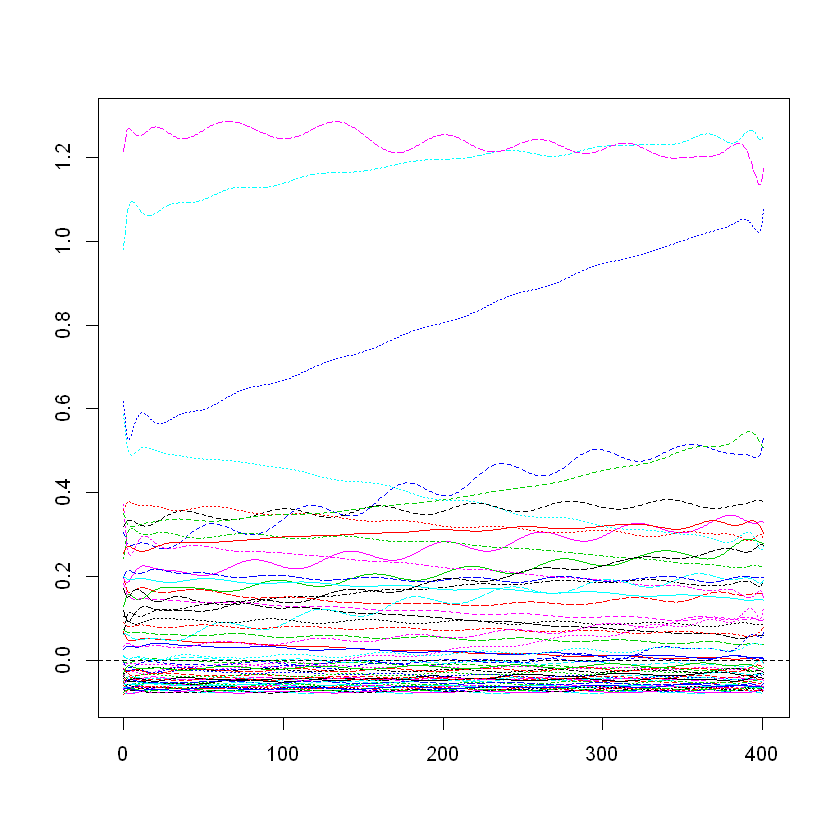

In [41]:
smallbasis  <- create.bspline.basis(rangeval = c(0, 401), nbasis = 25, 9)
#harmaccelLfd <- vec2Lfd(c(0,(2*pi/365)^2,0), c(0, 365))
harmFdpar = fdPar(smallbasis)
gasoline_fd <- smooth.basis(y = waves, fdParobj=smallbasis)$fd
gasoline_pcaObj = pca.fd(gasoline_fd, nharm = 4, harmfdPar = harmFdpar, centerfns = FALSE)
# 
plot(gasoline_fd, ylab="", xlab="",col="gray")

# here plot the fpc
#plot.pca.fd(gasoline_pcaObj, cex.main=0.9)

# Now simple FLR by creating xfdlist and betalist manually, but this is not neccesarly needed

In [42]:
xfdlist <- list(const=rep(1, 60), gasoline_fd=gasoline_fd)


[1] "done"

[1] 2.893931


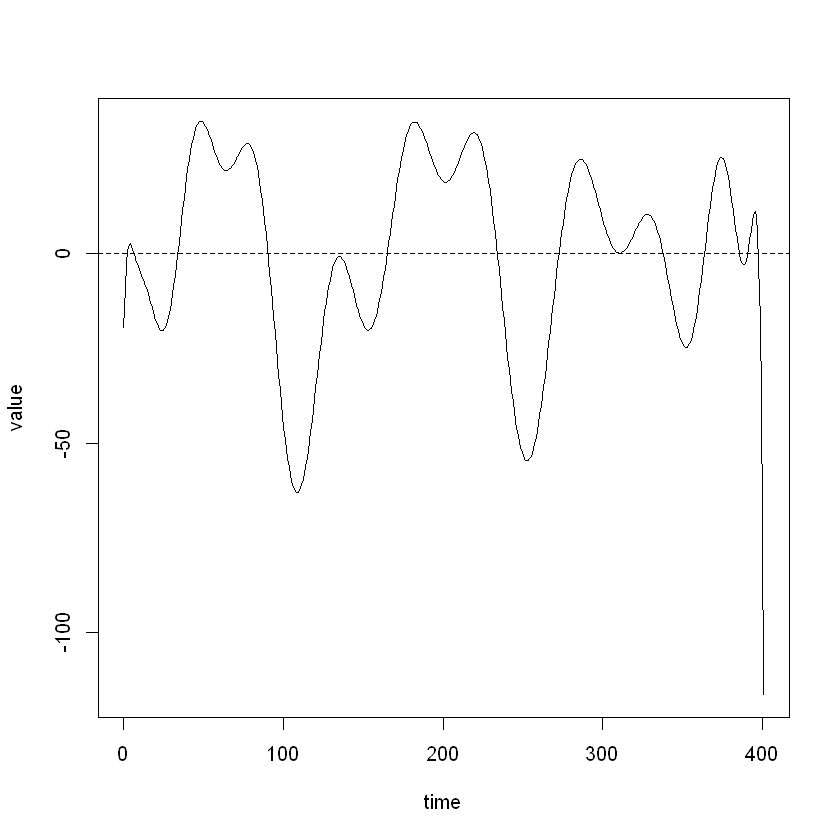

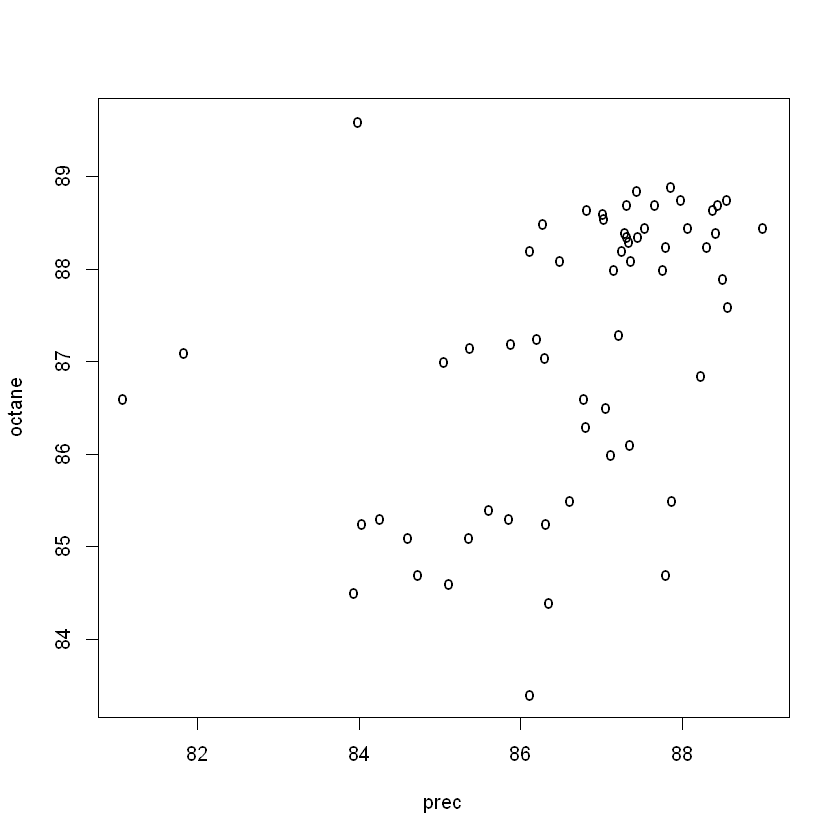

In [44]:
betabasis1 <- create.constant.basis(c(0, 60))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, 401), nbasis = 25, 9)
betafdPar2  <- fdPar(betafd2)

betalist <- list(const=betafdPar1, gasoline_fd=betafdPar2)

f_regress <- fRegress(y = octane, xfdlist, betalist)
# also possible to use formula interface:
f_regress2 <- fRegress(octane ~ gasoline_fd)

#names(f_regress)
#f_regress$betaestlist[[2]]
#  the vector of fits to the data is object  precip.Temp1$yfdPar,
#  but since the dependent variable is a vector, so is the fit
prec <- f_regress2$yhatfdobj

#  plot the data and the fit
plot(f_regress2$betaestlist[[2]])
MSE <- mean((octane-prec)^2)
print(MSE)
plot(prec, octane, type="p", pch="o")


# trying to set up FPCR

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),87.12350093,0.22039473,395.3066495,1.133061e-96
gasoline_pcaObj$scores1,0.01867296,0.03781456,0.4938033,6.234114e-01
gasoline_pcaObj$scores2,0.46734412,0.35388504,1.3206100,1.921005e-01
gasoline_pcaObj$scores3,2.23736360,2.41741217,0.9255201,3.587387e-01
gasoline_pcaObj$scores4,0.52087078,3.45110185,0.1509288,8.805841e-01


[1] "done"

[1] 2.18854


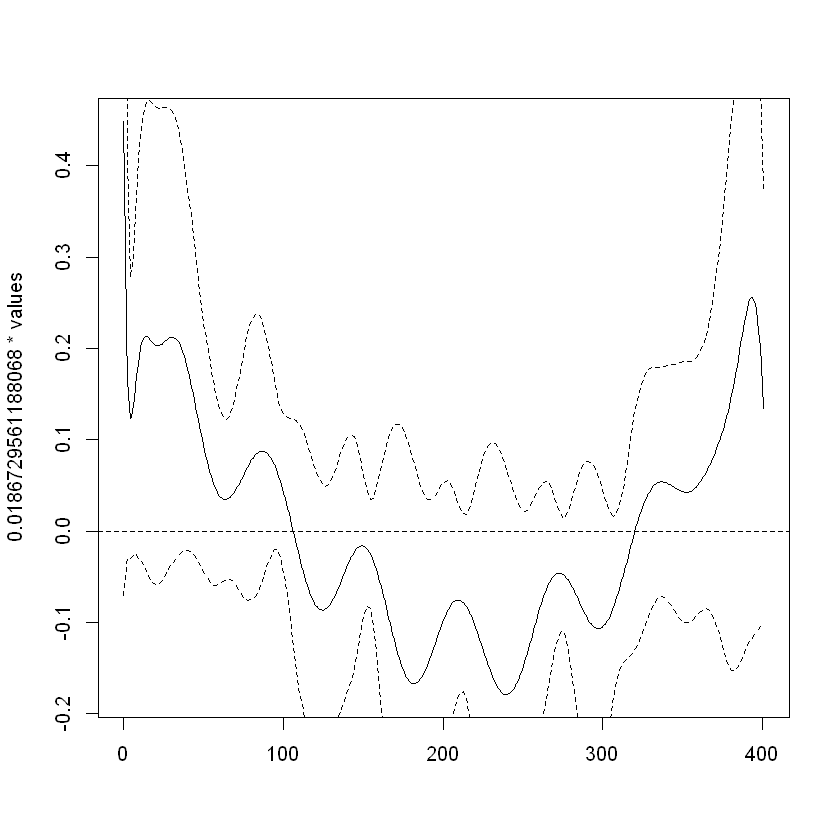

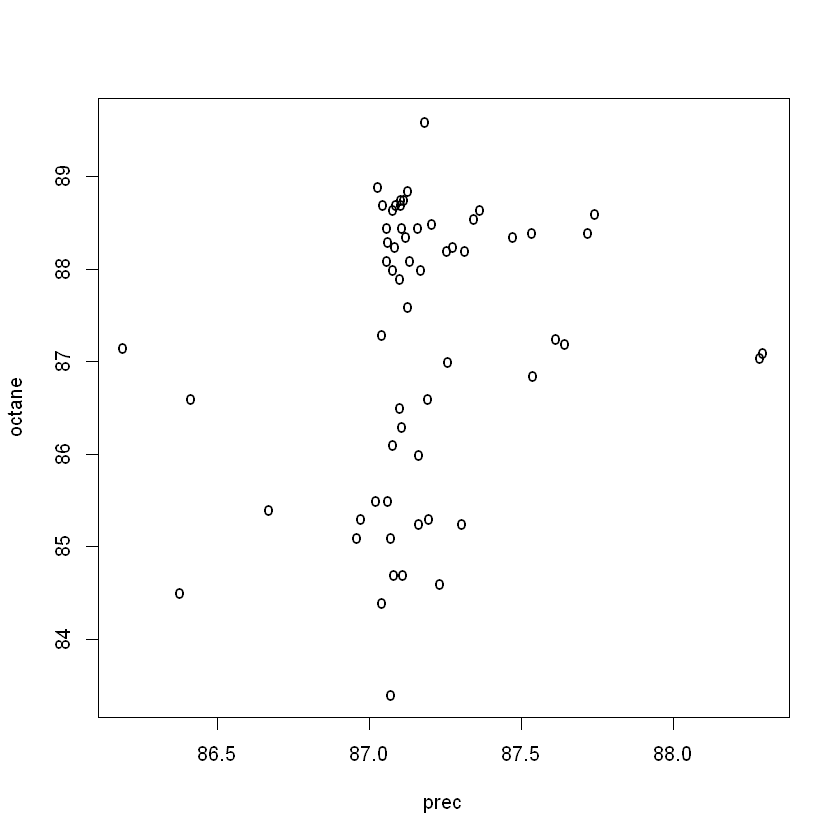

In [45]:
# manually create xfdlist and betalist
xfdlist <- list(const=rep(1, 60), gasoline_fd=gasoline_fd)

betabasis1 <- create.constant.basis(c(0, 60))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
# Here the magic happens! Create the betalist from the harmonics defined above
betafdPar2  <- fdPar(gasoline_pcaObj$harmonics)
betalist_pca <- list(const=betafdPar1, gasoline_fd=betafdPar2)

f_regress_pca <- lm(octane~gasoline_pcaObj$scores)
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs
betafd = pca_coeffs[2,1]*gasoline_pcaObj$harmonics[1] +
        pca_coeffs[3,1]*gasoline_pcaObj$harmonics[2] + 
        pca_coeffs[4,1]*gasoline_pcaObj$harmonics[3]+ 
        pca_coeffs[5,1]*gasoline_pcaObj$harmonics[4]


coefvar = pca_coeffs[,2]**2

betavar = pca_coeffs[2] * gasoline_pcaObj$harmonics[1]**2 +
          pca_coeffs[3] * gasoline_pcaObj$harmonics[2]**2 +
          pca_coeffs[4] * gasoline_pcaObj$harmonics[3]**2 + 
          pca_coeffs[5] * gasoline_pcaObj$harmonics[4]**2

plot(betafd)
lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
lines(betafd-2*sqrt(betavar), lty=2, lwd=1)


prec <- predict(f_regress_pca)
#  plot the data and the fit
MSE <- mean((octane-prec)^2)
print(MSE)
plot(prec, octane, type="p", pch="o")

# example from documentation

[1] "dailyAv"       "place"         "province"      "coordinates"  
[5] "region"        "monthlyTemp"   "monthlyPrecip" "geogindex"    
   St. Johns      Halifax       Sydney     Yarmouth   Charlottvl  Fredericton 
    3.170496     3.162863     3.168615     3.101231     3.079796     3.052271 
 Scheffervll       Arvida  Bagottville       Quebec   Sherbrooke     Montreal 
    2.903741     2.952599     2.969136     3.082283     3.045049     2.973497 
      Ottawa      Toronto       London  Thunder Bay     Winnipeg      The Pas 
    2.960328     2.893540     2.981366     2.847758     2.706888     2.652343 
   Churchill       Regina   Pr. Albert Uranium City     Edmonton      Calgary 
    2.611511     2.569491     2.609167     2.559548     2.667640     2.602603 
    Kamloops    Vancouver     Victoria   Pr. George   Pr. Rupert   Whitehorse 
    2.434409     3.062620     2.930236     2.784546     3.413601     2.434090 
      Dawson  Yellowknife      Iqaluit       Inuvik     Resolute 
    2.51

$coefs
          St. Johns       Halifax       Sydney      Yarmouth   Charlottvl
const   89.59970707  1.174930e+02  105.2605508  130.13365563   99.9635007
sin1   -74.67672652 -7.574673e+01  -85.1564381  -66.01326886  -83.8711152
cos1  -115.17887797 -1.497403e+02 -137.0944076 -119.05187489 -158.9254594
sin2     5.53204090 -1.130089e+00    0.5284220   -2.52955730   -4.3387519
cos2     4.23416905 -1.094302e+00    4.4478546   -3.92109330   -0.4619732
sin3    -8.77771637 -7.837793e+00  -10.5150346   -5.87660614   -9.5390259
cos3    -1.51415837 -2.946328e+00   -1.1950626   -0.71247689   -3.5766065
sin4     3.19273792  1.010561e+00    1.5078105    0.62071819    1.2626358
cos4     0.93816015 -1.110971e+00    0.5419630   -1.46190278   -0.8409562
sin5    -0.32883231  1.819621e+00    1.0011353    1.19233739    1.2610476
cos5     0.11601629  7.660468e-01    1.5064474    0.08912022    0.9696062
sin6     1.85054290  1.655562e+00    1.4854849    1.72596376    1.7348079
cos6    -1.92514224 -1.901784e+

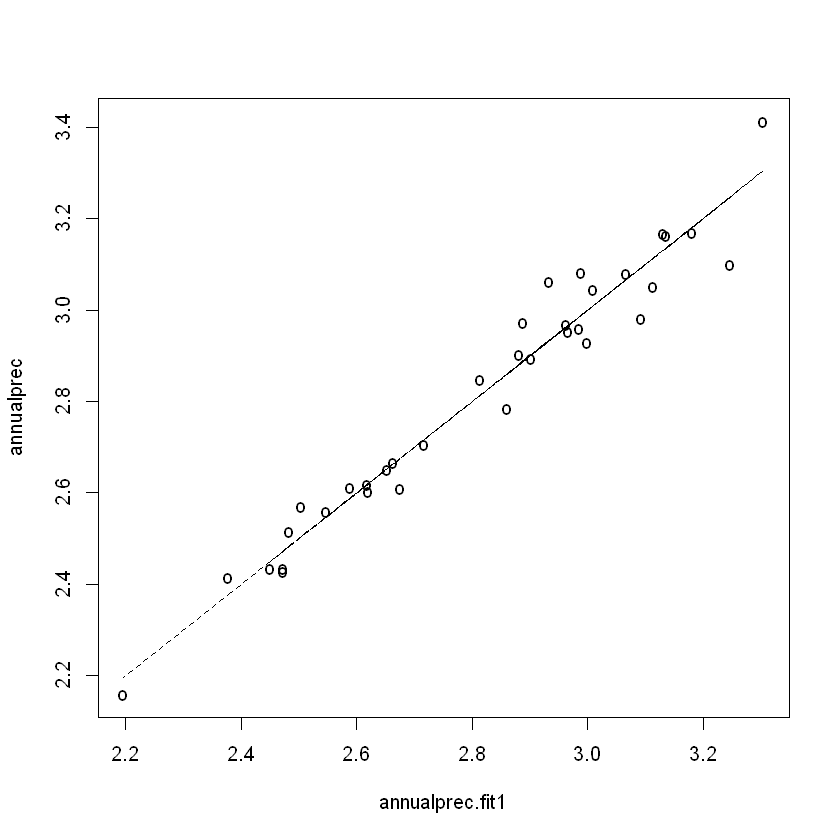

In [21]:
print(names(CanadianWeather))
#  set up log10 of annual precipitation for 35 weather stations
annualprec <- log10(apply(CanadianWeather$dailyAv[,,"Precipitation.mm"], 2,sum))
print(annualprec)
# The simplest 'fRegress' call is singular with more bases
# than observations, so we use only 25 basis functions, for this example
smallbasis  <- create.fourier.basis(c(0, 365), 25)
# The covariate is the temperature curve for each station.
tempfd <- smooth.basis(day.5,
          CanadianWeather$dailyAv[,,"Temperature.C"], smallbasis)$fd

##
## formula interface:  specify the model by a formula, the method
## fRegress.formula automatically sets up the regression coefficient functions,
## a constant function for the intercept, and a higher dimensional function
## for the inner product with temperature
##
#annualprec
tempfd
precip.Temp1 <- fRegress(annualprec ~ tempfd)

#  the output is a list with class name fRegress, display names
#names(precip.Temp1)
#  the vector of fits to the data is object  precip.Temp1$yfdPar,
#  but since the dependent variable is a vector, so is the fit
annualprec.fit1 <- precip.Temp1$yhatfdobj
#  plot the data and the fit
plot(annualprec.fit1, annualprec, type="p", pch="o")
lines(annualprec.fit1, annualprec.fit1, lty=2)